In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np 
import pandas as pd
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from textblob import TextBlob
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.size'] = 14
plt.rcParams['figure.figsize'] = (22, 5)
plt.rcParams['figure.dpi'] = 100

In [2]:
df = pd.read_csv('../input/hamasfacts/processed_fakevideo_withcomments.csv')
df.shape

(85228, 36)

In [3]:
df.head()

,News_ID,publish_date,Link,source_name,title,text,youtube_link,news_language,label,all_link,...,publishedAt,likeCount,authorDisplayName,commentText_processed,comment_language,Clean_Comments,polarity,sentiment,videotitle_contains_capitalized,title_length
0,gfc_2,2023-10-27 00:00:00+00:00,https://factnameh.com/fa/fact-checks/2023-10-2...,فکت‌نامه,golda meir and the palestinian passport,طی هفته‌های اخیر با بالا گرفتن جنگ حماس و اسرا...,https://www.youtube.com/watch?v=w3FGvAMvYpc,fa,گمراه‌کننده,NaN,...,2023-05-20T23:58:29Z,107.0,Sebastian Peretz,NaN,NaN,every single word said wisely thought thus men...,0.396,1,False,56
1,gfc_2,2023-10-27 00:00:00+00:00,https://factnameh.com/fa/fact-checks/2023-10-2...,فکت‌نامه,golda meir and the palestinian passport,طی هفته‌های اخیر با بالا گرفتن جنگ حماس و اسرا...,https://www.youtube.com/watch?v=w3FGvAMvYpc,fa,گمراه‌کننده,NaN,...,2023-01-10T22:27:12Z,157.0,sure why not,NaN,NaN,spoke three languages fluently detectable acce...,0.272,1,False,56
2,gfc_2,2023-10-27 00:00:00+00:00,https://factnameh.com/fa/fact-checks/2023-10-2...,فکت‌نامه,golda meir and the palestinian passport,طی هفته‌های اخیر با بالا گرفتن جنگ حماس و اسرا...,https://www.youtube.com/watch?v=w3FGvAMvYpc,fa,گمراه‌کننده,NaN,...,2018-09-16T16:24:02Z,148.0,elgrigorio1,NaN,NaN,we need leaders like her women men she knowled...,0.458,1,False,56
3,gfc_2,2023-10-27 00:00:00+00:00,https://factnameh.com/fa/fact-checks/2023-10-2...,فکت‌نامه,golda meir and the palestinian passport,طی هفته‌های اخیر با بالا گرفتن جنگ حماس و اسرا...,https://www.youtube.com/watch?v=w3FGvAMvYpc,fa,گمراه‌کننده,NaN,...,2023-10-21T20:05:04Z,12.0,Wasim Raja,NaN,NaN,what masterful interview prime minister1202310...,1.000,1,False,56
4,gfc_2,2023-10-27 00:00:00+00:00,https://factnameh.com/fa/fact-checks/2023-10-2...,فکت‌نامه,golda meir and the palestinian passport,طی هفته‌های اخیر با بالا گرفتن جنگ حماس و اسرا...,https://www.youtube.com/watch?v=w3FGvAMvYpc,fa,گمراه‌کننده,NaN,...,2023-10-13T19:47:49Z,15.0,Kelvin Quesenberry,NaN,NaN,what interview she wise answers…no fear critic...,0.322,1,False,56


In [4]:
df.columns

Index(['News_ID', 'publish_date', 'Link', 'source_name', 'title', 'text',
       'youtube_link', 'news_language', 'label', 'all_link', 'videoId',
       'video_url', 'video_title', 'video_author', 'video_length',
       'video_channel_id', 'video_channel_url', 'video_description',
       'video_publish_date', 'video_rating', 'video_thumbnail_url',
       'video_views', 'video_age_restricted', 'CommentsData', 'commentText',
       'replycount', 'publishedAt', 'likeCount', 'authorDisplayName',
       'commentText_processed', 'comment_language', 'Clean_Comments',
       'polarity', 'sentiment', 'videotitle_contains_capitalized',
       'title_length'],
      dtype='object')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85228 entries, 0 to 85227
Data columns (total 36 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   News_ID                          85228 non-null  object 
 1   publish_date                     85228 non-null  object 
 2   Link                             85228 non-null  object 
 3   source_name                      85228 non-null  object 
 4   title                            85228 non-null  object 
 5   text                             85228 non-null  object 
 6   youtube_link                     85228 non-null  object 
 7   news_language                    85228 non-null  object 
 8   label                            43995 non-null  object 
 9   all_link                         4639 non-null   object 
 10  videoId                          84983 non-null  object 
 11  video_url                        85228 non-null  object 
 12  video_title       

In [6]:
# mask NaNs
df["replycount"] = df["replycount"].fillna(value="")
df["likeCount"] = df["likeCount"].fillna(value="")
df["label"] = df["label"].fillna(value="")
df["publishedAt"] = df["publishedAt"].fillna(value="")
df["authorDisplayName"] = df["authorDisplayName"].fillna(value="")

In [8]:
pd.set_option('display.max_colwidth',30)

display(
    df.describe(include='object').loc[['unique','top','freq']],
    df.describe(include='bool').loc[['top','freq']]
)

,News_ID,publish_date,Link,source_name,title,text,youtube_link,news_language,label,all_link,...,video_publish_date,video_thumbnail_url,video_age_restricted,CommentsData,commentText,replycount,publishedAt,likeCount,authorDisplayName,Clean_Comments
unique,220,46,220,37,219,214,302,19,52,7,...,191,301,2,85090,69181,273,71077,1016.0,64246,85090
top,gfc_50,2023-10-13,https://www.logicallyfacts...,PolitiFact,victims of hamas attack on...,victims of hamas attack on...,https://www.youtube.com/wa...,en,,['https://mythdetector.ge/...,...,2023-10-09 00:00:00,https://i.ytimg.com/vi/8xQ...,False,<br>,❤,0,,0.0,,br
freq,2860,6039,2860,12696,2860,2860,1463,58544,41233,1306,...,4421,1463,78371,61,66,35246,13688,38864.0,13699,61


,videotitle_contains_capitalized
top,False
freq,46828


In [9]:
# unique data
items = []

for col in df.columns:
    items.append([col,df[col].nunique(),', '.join(df[col].unique()[0:5].astype(str))])

pd.set_option('display.max_colwidth',100)
pd.DataFrame(items,columns=[
    'Column','Unique Data Counts','5 Examples of Unique Data'
])

,Column,Unique Data Counts,5 Examples of Unique Data
0,News_ID,220,"gfc_2, gfc_3, gfc_8, gfc_9, gfc_13"
1,publish_date,46,"2023-10-27 00:00:00+00:00, 2023-10-26 00:00:00+00:00, 2023-10-23 00:00:00+00:00, 2023-10-17 00:0..."
2,Link,220,"https://factnameh.com/fa/fact-checks/2023-10-27-golda-meir-palestine-passport, https://factnameh..."
3,source_name,37,"فکت‌نامه, FACTLY, dpa Deutsche Presse-Agentur, المرصد الفلسطيني ” تحقق” , Youturn"
4,title,219,"golda meir and the palestinian passport, images of a festival in tibet instead of a refugee camp..."
5,text,214,طی هفته‌های اخیر با بالا گرفتن جنگ حماس و اسرائیل بار دیگر این بحث قدیمی که آیا دولت یا حکومت مس...
6,youtube_link,302,"https://www.youtube.com/watch?v=w3FGvAMvYpc, https://www.youtube.com/watch?v=yH4DxQP1Lj0, https:..."
7,news_language,19,"fa, en, de, ar, fr"
8,label,52,"گمراه‌کننده, نادرست, FALSE, MISLEADING, Deutschland ist keine Kriegspartei im Gaza-Krieg. Von de..."
9,all_link,7,"nan, ['/join/', '/'], [], ['/', 'https://profile.usatoday.com/newsletters/daily-briefing/', 'htt..."


In [14]:
#df['video_publish_date'] = pd.to_datetime(pd.to_datetime(df['video_publish_date']).dt.strftime("%Y-%m-%d"))
#df['publishedAt'] = pd.to_datetime(pd.to_datetime(df['publishedAt']).dt.strftime("%Y-%m-%d"))
#df['publish_date'] = pd.to_datetime(pd.to_datetime(df['publish_date']).dt.strftime("%Y-%m-%d"))


display(df[['video_publish_date','publishedAt']].dtypes,df[['video_publish_date','publishedAt']].iloc[[1,1000,2000]])

video_publish_date    datetime64[ns]
publishedAt           datetime64[ns]
dtype: object

,video_publish_date,publishedAt
1,2014-08-05,2023-01-10
1000,2020-10-12,NaT
2000,2020-10-12,2020-10-14


In [15]:
df["publishedAt"] = df["publishedAt"].fillna(value="")

In [17]:
df.videoId.dtypes

dtype('O')

In [20]:
# Duplicated video ID

vid_id_df = df.groupby('videoId').agg(Total_Publish_Date=('video_publish_date','nunique'))
pd.DataFrame(vid_id_df.value_counts())

,count
Total_Publish_Date,
1,301


In [23]:
title_list = []

for i in df['title']:
    title_list.append(len(i))

print('The longest title is',"'"+df.iloc[np.array(title_list).argmax()]['title']+"'.",
      '\nThe shortest title is',"'"+df.iloc[np.array(title_list).argmin()]['title']+"'.")

The longest video title is 'this video of cristiano ronaldo pulling the mic of a channel reporter has nothing to do with israel-palestine war.. the fact is this.. - fact crescendo malayalam'. 
The shortest video title is 'akhbarmeter'.


In [ ]:
channel_list = []

for i in data['channel_title']:
    channel_list.append(len(i))

print('The longest channel name is',"'"+data.iloc[np.array(channel_list).argmax()]['channel_title']+"'.",
      '\nThe shortest channel name is',"'"+data.iloc[np.array(channel_list).argmin()]['channel_title']+"'.")

In [5]:
#Downloading the model and the tokenizer
tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

model = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

In [6]:
tokens = tokenizer.encode(df['Clean_Comments'][0], return_tensors='pt')
result = model(tokens)
print(f'The sentiment of the first comment is {int(torch.argmax(result.logits))+1}')

The sentiment of the first comment is 5


In [7]:
def sentiment_score(comment):
    tokens = tokenizer.encode(comment, return_tensors='pt')
    result = model(tokens)
    return int(torch.argmax(result.logits))+1

In [9]:
for i in range(0,10):
    score = sentiment_score(df['Clean_Comments'][i])
    comment = df['Clean_Comments'][i]
    print(f'Comment : {comment[0:100]}, Score : {score}.')
    print('\n')

Comment : every single word said wisely thought thus mentioned what intelligent brillant honest woman a true h, Score : 5.


Comment : spoke three languages fluently detectable accent english yiddish hebrew to able climb top israeli po, Score : 5.


Comment : we need leaders like her women men she knowledgeable straightforward no political correc5ness said s, Score : 5.


Comment : what masterful interview prime minister120231021t200504z12wasim raja, Score : 5.


Comment : what interview she wise answers…no fear criticized… truth needs defense also questions asked straigh, Score : 1.


Comment : i wrote high school essay golda she one hero’s not i jew strong individual character impressive72022, Score : 5.


Comment : i saw film golda brought here what magnificent leader example countries220230908t090416z37m eve “eve, Score : 5.


Comment : i love way handles interview 💪020230928t212303z21hon dah, Score : 5.


Comment : this first time i heard speakwas amazing see clarity thought well 

In [10]:
df.sort_values(by='polarity',ascending= False).head()

,News_ID,publish_date,Link,source_name,title,text,youtube_link,news_language,label,all_link,...,publishedAt,likeCount,authorDisplayName,commentText_processed,comment_language,Clean_Comments,polarity,sentiment,videotitle_contains_capitalized,title_length
80687,snopes_9,2023-10-25 21:28:48+00:00,https://www.snopes.com/fact-check/turkey-warsh...,snopes,Does Video Show Turkey Moving a Warship Toward...,"Claim: In October 2023, a video showed Turkey ...",https://www.youtube.com/watch?v=VETFFYo92e4&t=58s,en,NaN,"['/join/', '/']",...,2014-05-09T23:29:22Z,0.0,Woke up and smell the coffee,NaN,NaN,truly awesome footage land u vid 020140509t232...,1.0,1,True,92
47590,pubmedia_48,2023-10-27,https://thedispatch.com/article/i-ignored-base...,The Dispatch,I Ignored Baseball for Decades. Here’s What It...,One of my happiest childhood memories is watch...,https://www.youtube.com/watch?v=N4nwMDZYXTI,en,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,rest peace vin scully rest in peace vin greate...,1.0,1,True,52
47730,pubmedia_48,2023-10-27,https://thedispatch.com/article/i-ignored-base...,The Dispatch,I Ignored Baseball for Decades. Here’s What It...,One of my happiest childhood memories is watch...,https://www.youtube.com/watch?v=N4nwMDZYXTI,en,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,a perfect 10 mins baseball commentary020201103...,1.0,1,True,52
47741,pubmedia_48,2023-10-27,https://thedispatch.com/article/i-ignored-base...,The Dispatch,I Ignored Baseball for Decades. Here’s What It...,One of my happiest childhood memories is watch...,https://www.youtube.com/watch?v=N4nwMDZYXTI,en,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,the greatest homerun dodger history020220410t1...,1.0,1,True,52
36857,gfc_468,2023-10-11 00:00:00+00:00,https://en.youturn.in/factcheck/slogans-in-ira...,Youturn,slogans in iranian parliament against the kill...,claim\n\niran parliament chants ‘death to isra...,https://www.youtube.com/watch?v=r_f8JxrcYNk,en,Misleading,NaN,...,2020-01-05T17:33:35Z,0.0,Magma Sunburst,NaN,NaN,wouldn&39t wonderful iran could start forgive ...,1.0,1,True,61


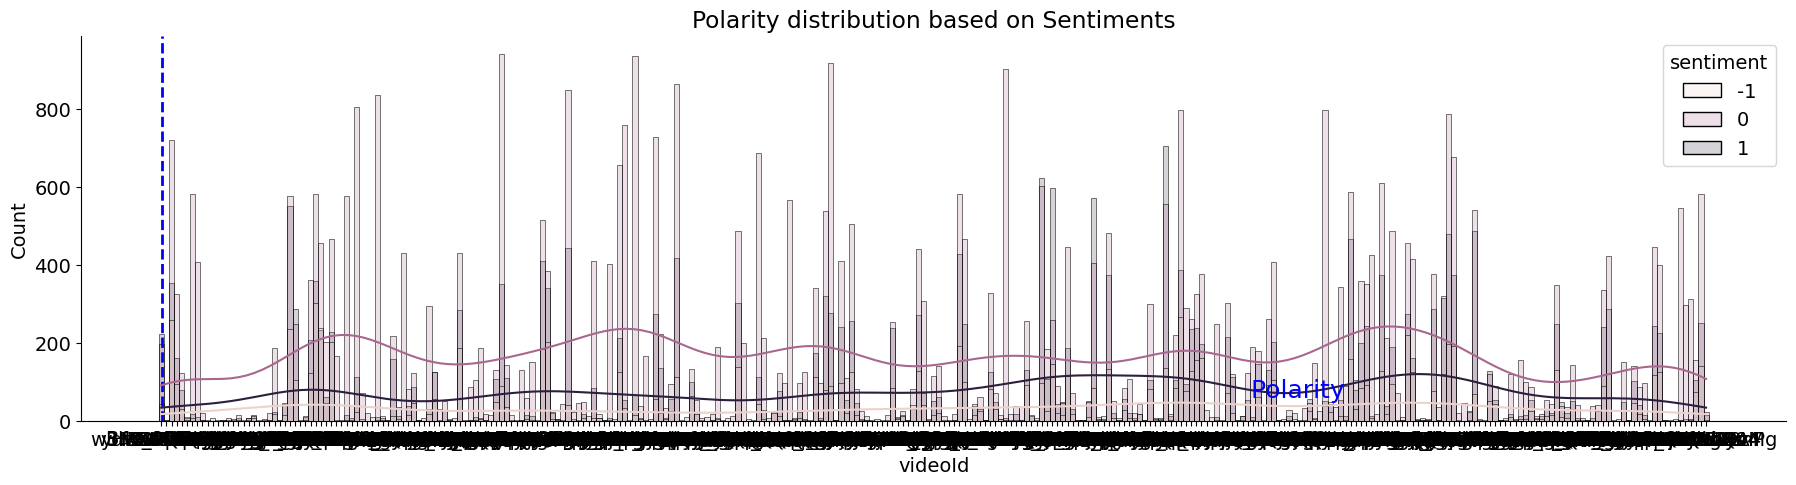

In [23]:
sns.histplot(data=df, x=df['videoId'], hue='sentiment', kde=True, alpha=0.2)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.axvline(df['polarity'].mean(), linestyle='--', lw=2, zorder=1, color='blue')
plt.annotate(f' Polarity', (210, 60), fontsize=18,color='blue')
plt.title('Polarity distribution based on Sentiments')
plt.show()

Text(0.5, 1.0, 'Polarity histogram')

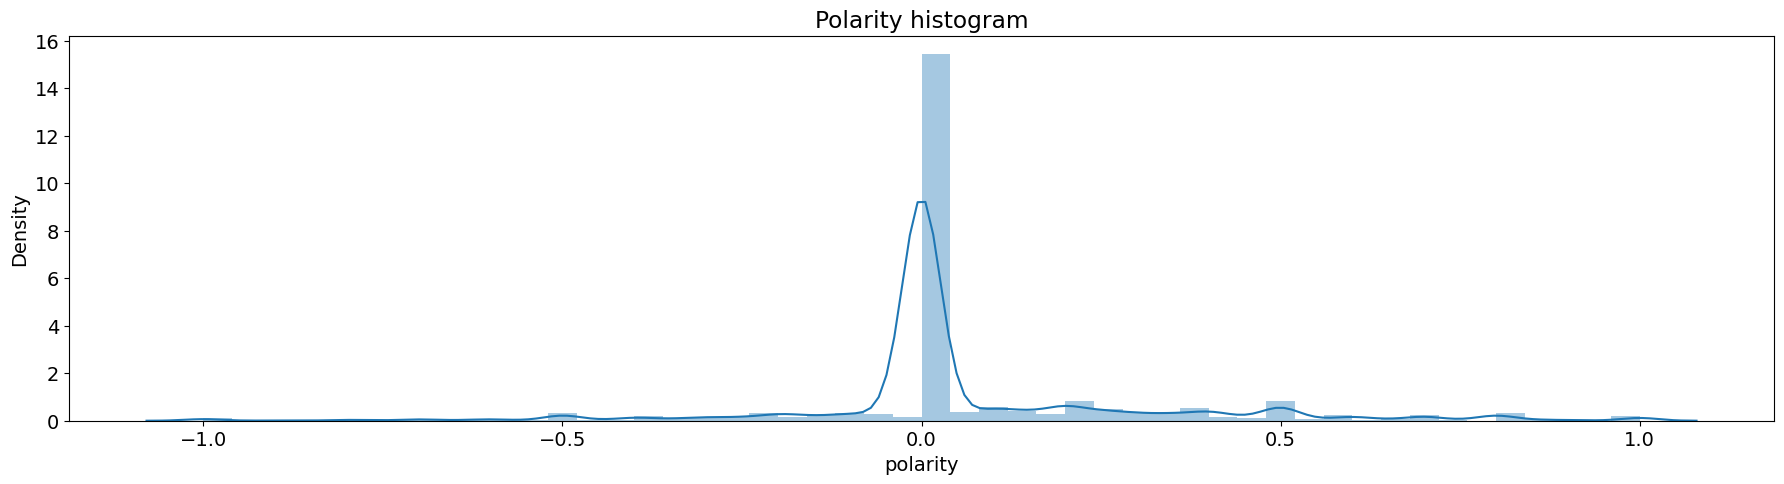

In [27]:
#df.polarity.value_counts().plot.bar()
#df.polarity.value_counts()
sns.distplot(df['polarity'])
plt.title("Polarity histogram")

In [18]:
df['publishedAt']

0        2023-05-20T23:58:29Z
1        2023-01-10T22:27:12Z
2        2018-09-16T16:24:02Z
3        2023-10-21T20:05:04Z
4        2023-10-13T19:47:49Z
                 ...         
85223    2023-10-10T06:24:39Z
85224    2023-10-18T01:11:00Z
85225    2023-10-27T03:57:36Z
85226    2023-10-17T07:07:53Z
85227    2023-10-10T07:19:09Z
Name: publishedAt, Length: 85228, dtype: object

In [ ]:
plt.style.use('seaborn-dark')
plt.plot(dates, polarization)
plt.xticks(rotation=80)
plt.title("Ukraine War Twitter Polarization")

plt.show()

In [8]:
df['sentiment'].value_counts('pct')

sentiment
 0    0.609283
 1    0.273537
-1    0.117180
Name: proportion, dtype: float64

In [ ]:
df['polarity'].value_counts()